<a href="https://colab.research.google.com/github/joshbrx/biomath_model/blob/main/healthy_GRN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Healthy GRN in pancreas model for stellate cells.

Para modelar correctamente la red de regulación genética, renormbraremos las variables del sistema para poder simplificar el proceso

| $TNF_a$ | $TGFb_1$ | $RAS$ | $P53$ | $PIP3$ | $ERK$ | Apoptosis | Proliferation |
|:-------:|:--------:|:-----:|:-----:|:------:|:-----:|:-----------:|:---------------:|
|  $X_1$  |   $X_2$  | $Y_1$ | $Y_2$ |  $Y_3$ | $Y_4$ |    $Z_1$    |      $Z_2$      |

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

from scipy import signal
from ipywidgets import interact
import ipywidgets as widgets
%matplotlib inline
# sns.set_style("whitegrid")
sns.set_style("darkgrid")
sns.set_context("paper")

In [15]:
def supr(e, n, s):
    return e/(1 + s**n)

interactive(children=(FloatSlider(value=9.5, description='n', max=10.0, min=-10.0, step=1.0), Output()), _dom_…

<function __main__.plot_supr(n)>

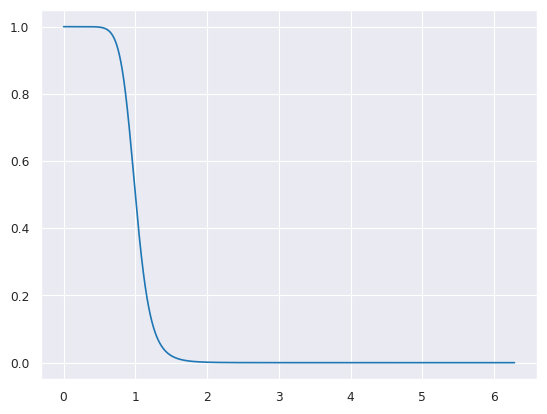

In [16]:
def plot_supr(n):
    x = np.linspace(0, 2*np.pi, 2000)
    y = supr(1, n, x)
    plt.plot(x, y);

interact(plot_supr, n = widgets.FloatSlider(value=9.5, min=-10, max=10, step=1))

In [28]:
def dS(S, i, y1_tau1, X1, X2):
    y1, y2, y3, y4, z1, z2, Ry1, Ry2, Ry3, Ry4, Rz1, Rz2 = S
    # --------------------------------------------------------
    dRy1 = e[0]*(supr(1, n[0], X1[i]) + supr(1, n[0], y1_tau1) + supr(1, n[0], y3) + supr(1, n[0], y4)) - Ry1;
    dy1  = supr(1, n[1], Ry1) - y1;         # 1/0.4

    dRy2 = e[1]*(supr(1, n[0], y1) + (supr(1, -n[0], y2) * supr(1, -n[0], y3))) - Ry2
    dy2  = supr(1, n[1], Ry2) - y2;         # 1/2.14 o 1/2.1

    dRy3 = e[2]*(supr(1, n[0], X2[i]) + supr(1, n[0], y1) + supr(1, -n[0], y2)) - Ry3
    dy3  = supr(1, n[1], Ry3) - y3;         # 1/2.14

    dRy4 = e[3]*(supr(1, n[0], X2[i]) + supr(1, n[0], y1)) - Ry4;
    dy4  = supr(1, n[1], Ry4) - y4;         # 1/0.35
    # --------------------------------------------------------
    # dRz1 = dRy2; dz1  = dy2;
    dRz2 = e[4]*(supr(1, -n[0], y2) + supr(1, n[0], y4)) - Rz2
    dz2  = supr(1, n[1], Rz2) - z2;         # 1/1.15
    # --------------------------------------------------------
    dS = [dy1, dy2, dy3, dy4, dy2, dz2, dRy1, dRy2, dRy3, dRy4, dRy2, dRz2]
    return np.array(dS)

In [29]:
def RK_solver(S0, t, tau1, X1, X2):
    dims = len(S0)
    K = np.empty([4, dims])
    S = np.zeros([2*len(t)+1, dims])

    for d in range(dims):
        S[0, d] = S0[d]

    dt = t[1] - t[0];
    for i in range(len(t)):
        y1_tau1 = S[i-int(tau1), 0]
        K[0] = dt * dS(S[i]         , i, y1_tau1, X1, X2)
        K[1] = dt * dS(S[i] + K[0]/2, i, y1_tau1, X1, X2)
        K[2] = dt * dS(S[i] + K[1]/2, i, y1_tau1, X1, X2)
        K[3] = dt * dS(S[i] + K[2]  , i, y1_tau1, X1, X2)
        for d in range(dims):
            S[i+1, d] = S[i, d] + (K[0,d]+2*K[1,d]+2*K[2,d]+K[3,d])/6
    return S[1:len(t)+2, :]

In [30]:
# parámetros
n = [-4, -20]
e = [1/0.4, 1/1.2, 1/2.14, 1/0.35, 1/1.15]
start=0; step=0.1; num=42000
t = np.arange(0.001, num)*step + start

S0 = np.concatenate([np.array([1, 0, 1, 1, 0, 1]), np.zeros(6)])   # R, Y, Z

In [33]:
labels = ["RAS","P53","PIP3","ERK","$Apop_s$","$Prolif_s$"]

def plot_healthy_GRN(T, tau1, n_exp):
    X1, X2 = (0.5*(np.sin(t/T)+1))**n_exp, (0.5*(np.cos(t/T)+1))**n_exp
    Pip = RK_solver(S0, t, tau1, X1, X2)
    fig = plt.figure(figsize=(16,8), dpi=100); gs = fig.add_gridspec(2, hspace=0.05)
    axs = gs.subplots(sharex=True)
    # axs = gs.subplots()
    for i in range(4):
        axs[0].plot(t/3.016241, Pip[1:,i], label=labels[i])
    for i in range(2):
        axs[1].plot(t/3.016241, Pip[1:,i+4], label=labels[i+4])
    axs[0].legend(loc="upper left", bbox_to_anchor=(1, 1)); axs[0].set_xlim([t[0], t[-1]/3.0162411]);  axs[0].set_ylim([-0.05, 1.05])
    axs[0].axvline(tau1/10/3.016241, color="black")

    axs[1].legend(loc="upper left", bbox_to_anchor=(1, 1)); axs[1].set_xlim([t[0], t[-1]/3.016241]);  axs[1].set_ylim([-0.05, 1.05])
    axs[1].axvline(tau1/10/3.016241, color="black")
    fig.text(0.32, 0.91, f"Perfil de expresión genética en un Páncreas sano, \t $T=${round(T/3.016241,3)} días", va='center', fontsize=16)

    plt.xlabel(r"Tiempo, $t$ [días]", fontsize=12)
    fig.text(0.09, 0.5, r"Amplitud, $A(t)$ [ua]", va='center', rotation='vertical', fontsize=12)
    plt.show()


In [34]:
interact(plot_healthy_GRN, T = widgets.FloatSlider(value=1.95, min=0.1, max=10, step=0.01),
                        tau1 = widgets.FloatSlider(value=1590, min=1000, max=5000, step=1),
                       n_exp = widgets.FloatSlider(value=2.06, min=1.7, max=2.5, step=0.001))

interactive(children=(FloatSlider(value=1.95, description='T', max=10.0, min=0.1, step=0.01), FloatSlider(valu…

<function __main__.plot_healthy_GRN(T, tau1, n_exp)>

<ipython-input-15-c9dcc9093113>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return e/(1 + s**n)


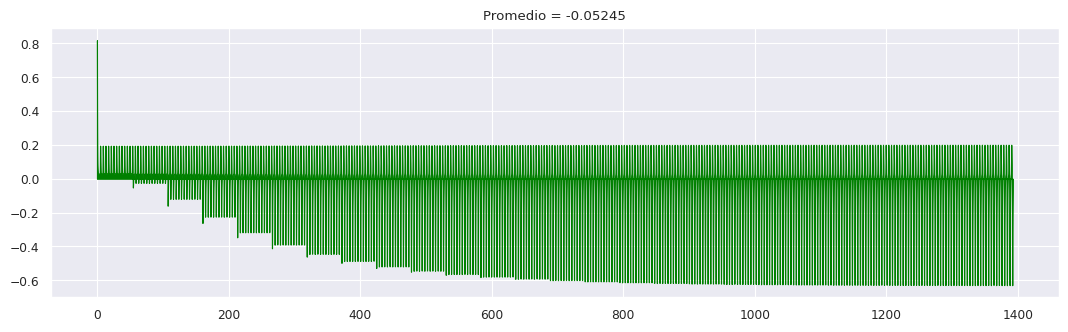

Apop:	 0.13698401947910593 
Prolif:	 0.0845110369907648


In [40]:
T, tau1, n_exp = 1.95, 1590, 2.06
X1, X2 = (0.5*(np.sin(t/T)+1))**n_exp, (0.5*(np.cos(t/T)+1))**n_exp
Pip = RK_solver(S0, t, tau1, X1, X2)

plt.figure(figsize=(13,3.5), dpi=100)
plt.fill_between(t/3.016241, -Pip[1:,4] + Pip[1:,5], color="green")
# plt.fill_between(t, -A[0]*Pip[1:,4] + A[1]*Pip[1:,5])
# plt.title(f"Promedio = {round(np.mean(-A[0]*Pip[:,4] + A[1]*Pip[:,5]), 6)}"); plt.show()
plt.title(f"Promedio = {round(np.mean(-Pip[:,4] + Pip[:,5]), 6)}"); plt.show()
print("Apop:\t", np.mean(Pip[1:,4]), "\nProlif:\t", np.mean(Pip[1:,5]))